In [17]:
import geopandas as gpd
import pandas as pd
from glob import glob
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [18]:
def ag_func(df):
    d = {}
    d['tasmax'] = df['tasmax'].mean()
    d['tasmin'] = df['tasmin'].mean()
    d['pr'] = df['pr'].sum()
    return pd.Series(d)

def aggregate_by_model(df, model_name, month_range=(6,8), year_range=(2006,2100)):
    query = df.xs(model_name, level='model')
    query = query[(query.index.year >= year_range[0]) & (query.index.year <= year_range[1])]
    query = query[(query.index.month >= month_range[0]) & (query.index.month <= month_range[1])]
    q_agg = query.groupby([query.index.year, \
                           query.index.month]).apply(ag_func)
    q_agg.index.names = ['year', 'month']
    columns = [(f'{model_name}',n) for n in q_agg.columns.values]
    q_agg.columns = pd.MultiIndex.from_tuples(columns)
    return q_agg

def create_gcm_summary(filename):
    #df = pd.read_csv(glob(f'{wd}/*{s}*')[0], chunksize=1e5)
    df = dd.read_csv(filename)
    df['img_date'] = df['img_date'].astype('datetime64')
    df['tasmin'] = df['tasmin'] - 273.15
    df['tasmax'] = df['tasmax'] - 273.15
    df['pr'] = df['pr'] * 86400
    model_list = np.unique(np.array([v[1] for v in groups.index.values]))
    df_summary = pd.concat([aggregate_by_model(groups, model) for model in model_list],\
                       axis=1).dropna()
    df_summary.columns.names = ['model', 'scenario']
    return df_summary

# 10 Percentile
def qlower(x):
            return x.quantile(0.1)

# 90 Percentile
def qupper(x):
            return x.quantile(0.9)
 

In [19]:
#BUCKET = 'ikh-nart'
BUCKET = 'rio-mora'
rcp = 85
if BUCKET=='ikh-nart':
    alias = 'wdpa-99848'
    plot_month_range = (6,10)
else:
    alias = 'wdpa-555609346'
    plot_month_range = (4,10)
datadir = f'/datadrive/{BUCKET}/data/{alias}/'
points = pd.read_csv(f'{datadir}/{alias}_points_v1.csv')
gcmfile = f'{datadir}/GDDP_rcp{rcp}_{alias}_v1.csv' 

scenario_list = ['rcp45', 'rcp85']
s = scenario_list[0]
#df = pd.read_csv(glob(f'{wd}/*{s}*')[0], chunksize=1e5)
#df = dd.read_csv(glob(f'{wd}/*{s}*')[0])
df = dd.read_csv(gcmfile)
df['img_date'] = df['img_date'].astype('datetime64')
df['tasmin'] = df['tasmin'] - 273.15
df['tasmax'] = df['tasmax'] - 273.15
df['pr'] = df['pr'] * 86400
groups = df.groupby(['img_date','model'])['tasmax','tasmin','pr'].mean().compute()
#get the list of model names
model_list = np.unique(np.array([v[1] for v in groups.index.values]))
#execute summary
seasonal_months = {'JFM':(1,3),'AMJ':(4,6),'JAS':(7,9),'OND':(10,12)}
df_seasonal = {}

for season,month_range in seasonal_months.items():
    #take the mean of all the points 
    df_summary = pd.concat([aggregate_by_model(groups, model, month_range) for model in model_list],\
                           axis=1).dropna()
    df_summary.columns.names = ['model', 'climate']
    df_seasonal[season] = df_summary.copy()

df_summary = pd.concat([aggregate_by_model(groups, model, plot_month_range) for model in model_list],\
                       axis=1).dropna()
df_summary.columns.names = ['model', 'climate']
climate_vars = df_summary.columns.levels[-1].values

#df_summary.to_csv(f'{wd}/GDDP_processed.csv')

,tasmin,tasmax,pr,img_date,location,model,scenario
npartitions=70,,,,,,,
,float64,float64,float64,datetime64[ns],object,object,object
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


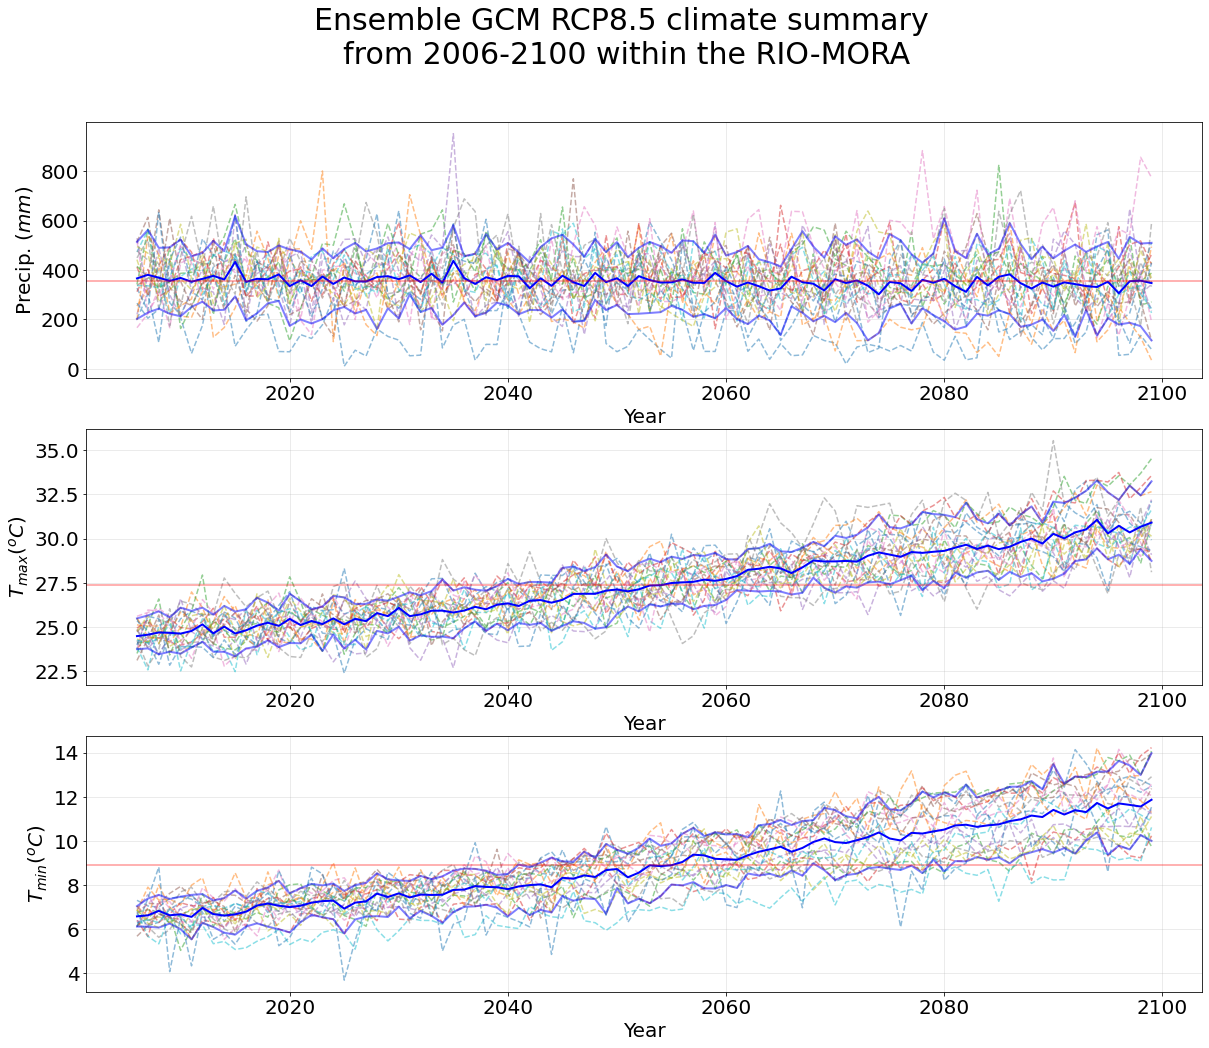

In [21]:
#plot time series

f, ax = plt.subplots(len(climate_vars),1,figsize=(20,16))
var_labels = {'pr':'Precip. ($mm$)', \
              'tasmax':'$T_{max}$($^oC$)', \
              'tasmin':'$T_{min}$($^oC$)'}
for i, var in enumerate(climate_vars):
    if var == 'pr':
        summary = df_summary.groupby('year').agg('sum').xs(var, level='climate', axis=1)
    else:
        summary = df_summary.groupby('year').agg('mean').xs(var, level='climate', axis=1)
    summary.plot(ax=ax[i], ls='--',alpha=0.5, legend=False)
    gcm_mean = summary.agg('mean', axis=1)
    gcm_mean.plot(ax=ax[i], lw=2, color='blue')
    gcm_lower = summary.agg(qlower, axis=1)
    gcm_lower.plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    gcm_upper = summary.agg(qupper, axis=1)
    gcm_upper.plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    ax[i].axhline(gcm_mean.mean(), color='red', alpha=0.3, lw=2)
    ax[i].grid(alpha=0.3)
    ax[i].set_ylabel(var_labels[var], fontsize=20)
    ax[i].set_xlabel('Year',fontsize=20)
#    ax[i].set_xticklabels(fontsize=20)
#    ax[i].set_yticklabels(fontsize=20)
    ax[i].tick_params(axis='both', labelsize=20)
f.suptitle(f'Ensemble GCM RCP8.5 climate summary \nfrom 2006-2100 within the {BUCKET.upper()}',\
          fontsize=30)
f.savefig(f'./figs/{BUCKET}_gcmseries.png',dpi=300,bbox_width='tight')


In [59]:
#print in LaTeX table style
climate_vars = df_summary.columns.levels[-1].values
seasonal_avgs = {v:{} for v in climate_vars}
trends = {v:{} for v in climate_vars}
for season,df_summary in df_seasonal.items():
    for i, var in enumerate(climate_vars):
        if var == 'pr':
            summary = df_summary.groupby('year').agg('sum').xs(var, level='climate', axis=1)
        else:
            summary = df_summary.groupby('year').agg('mean').xs(var, level='climate', axis=1)
        season_aggregate = summary.agg('mean', axis=1)
        seasonal_avgs[var][season] = season_aggregate
        
        reg = linear_model.LinearRegression()
        y = season_aggregate.values
        X = np.array(season_aggregate.index).reshape(-1,1)
        #X = np.arange(len(y)).reshape(-1,1)
        result = reg.fit(X,y)
        trends[var][season] = result.coef_
labels = ['Cumulative Precip. ($\\frac{mm}{years_{100}}$)',\
          'Mean $T_{max}$ ($\\frac{^oC}{years_{100}}$)', \
          'Mean $T_{min}$ ($\\frac{^oC}{years_{100}}$)']
print('\\begin{table}[h]')
print('\\centering')
print('\\begin{tabular}{lllll}')
print('\\toprule')
print('&', end='')
for k,_ in seasonal_months.items():
    print('\\textbf{%s} & '%k, end='')
print('\\\\')
for l,(_,v) in zip(labels,trends.items()):
    print('\\textbf{%s} & '%l, end='')
    for _,v in v.items():
        print('%0.2f & '%(v*100), end='')
    print('\\\\')
print('\\bottomrule')
print('\\end{tabular}')
print('\\caption{}')
print('\\end{table}')


\begin{table}[h]
\centering
\begin{tabular}{lllll}
\toprule
&\textbf{JFM} & \textbf{AMJ} & \textbf{JAS} & \textbf{OND} & \\
\textbf{Cumulative Precip. ($\frac{mm}{years_{100}}$)} & 0.00 & 7.62 & 24.65 & 0.06 & \\
\textbf{Mean $T_{max}$ ($\frac{^oC}{years_{100}}$)} & 5.62 & 5.86 & 6.67 & 6.27 & \\
\textbf{Mean $T_{min}$ ($\frac{^oC}{years_{100}}$)} & 6.88 & 5.70 & 6.69 & 6.95 & \\
\bottomrule
\end{tabular}
\caption{}
\end{table}


In [ ]:
#now apply the historic record of climate for the region
#aggregated rate of change by season (3month) by region

In [ ]:
#do a for loop within each model
#generate a new master list that is an aggregate by model
#plot these over time
#repeat for Rio-Mora